# ineffiecient ecosystems 

identifying areas in space and time where high NDVI and low GPP co-occur


**steps:**

* identify high NDVI and low GPP (g C m^-2 d^-1)
    - time series decomposition for each pixel --> which method? use statsmodels ? 
    - 'simple' correlation? (pixelwise correlation along time dimension?) --> but does that give information about when the ecosystem is inefficient? correlation per season? 
* set threshold for anomalies (duration? intensity?) 'seasonal inefficiency' ?
* where and when do they co-occur? --> how to visualize?
    - bivariate choropleth map?
    - 'sum of inefficient days' per pixel?
    - plot of (in)efficient ecosystem with colourcode by season?
* find explainations
    - water scarcity
    - occurence in specific seasons or biomes? 
    - relation to vegetation period?
    - relation to dominant plant type?

In [6]:
%pwd

'/home/sc.uni-leipzig.de/uk01ejut/ESA'

### packages

In [2]:
import numpy as np
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose ### STL


### cube access

In [174]:

### cube from cluster - differently chunked (?) version: esdc-8d-0.25deg-256x128x128-3.0.2.zarr
#cube_path = "/software/databases/rsc4earth/EarthSystemDataCube/v3.0.2/esdc-8d-0.25deg-1x720x1440-3.0.2.zarr"

### subcube (local download)
#cube_path = "ndvi_gpp_cube_subset_nonans.nc" ### without empty pixels
cube_path = "ndvi_gpp_cube_subset_wnans.nc"  ### with nan/ empty pixels

#cube = xr.open_zarr(cube_path)
cube = xr.open_dataset(cube_path)
cube

<xarray.Dataset> Size: 709kB
Dimensions:                     (time: 276, lat: 20, lon: 16)
Coordinates:
  * lat                         (lat) float64 160B 43.12 43.38 ... 47.62 47.88
  * lon                         (lon) float64 128B 13.12 13.38 ... 16.62 16.88
  * time                        (time) datetime64[ns] 2kB 2010-01-05 ... 2015...
Data variables:
    ndvi                        (time, lat, lon) float32 353kB ...
    gross_primary_productivity  (time, lat, lon) float32 353kB ...
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

### data prep

* check whether the variables of interest cover the same temporal range - if not, slice and interpolate gaps (but there shouldn't be...)


* discard pixels that are not covered by both variables and other invalid pixel values (e.g NDVI < 0, GPP < 0)

In [3]:
print(cube.ndvi.time.min().values)
print(cube.ndvi.time.max().values)
print(cube.gross_primary_productivity.time.min().values)
print(cube.gross_primary_productivity.time.max().values)

1979-01-05T00:00:00.000000000
2021-12-31T00:00:00.000000000
1979-01-05T00:00:00.000000000
2021-12-31T00:00:00.000000000


In [3]:
### spatiotemporal subset to try time series decomposition

#subcube = cube.sel(time=slice("2010-01-01", "2015-12-31"))

#subcube = subcube.sel(lat=slice(43., 48.), lon=slice(13.,17.)) ###.sel(lat=slice(48., 54.), lon=slice(20., 30.)) ###.sel(lat=slice(43.20, 54.90), lon=slice(13.20, 32.20)) <-- with NaNs

In [4]:
### select variables of interest
#subcube = subcube[["ndvi", "gross_primary_productivity"]]
#subcube

In [ ]:
#subcube.to_netcdf("ndvi_gpp_cube_subset.nc")

In [8]:
### interpolate temporal gaps (are there any, isnt't the cube already gapfilled?)

### but only where there are enough values ...

#def interpolate_ds(ds, method="linear"):
#    return ds.interpolate_na(dim="time", method=method)

#subcube = interpolate_ds(subcube, method="linear")

In [175]:
cube["ndvi"] = cube["ndvi"].where(cube["ndvi"]>=0)
cube["gross_primary_productivity"] = cube["gross_primary_productivity"].where(cube["gross_primary_productivity"]>=0)

## easy try

* no all-nan pixels ---> error when apply_ufunc
* only one variable (NDVI)

In [176]:
ndvi = cube["ndvi"]
gpp = cube["gross_primary_productivity"]

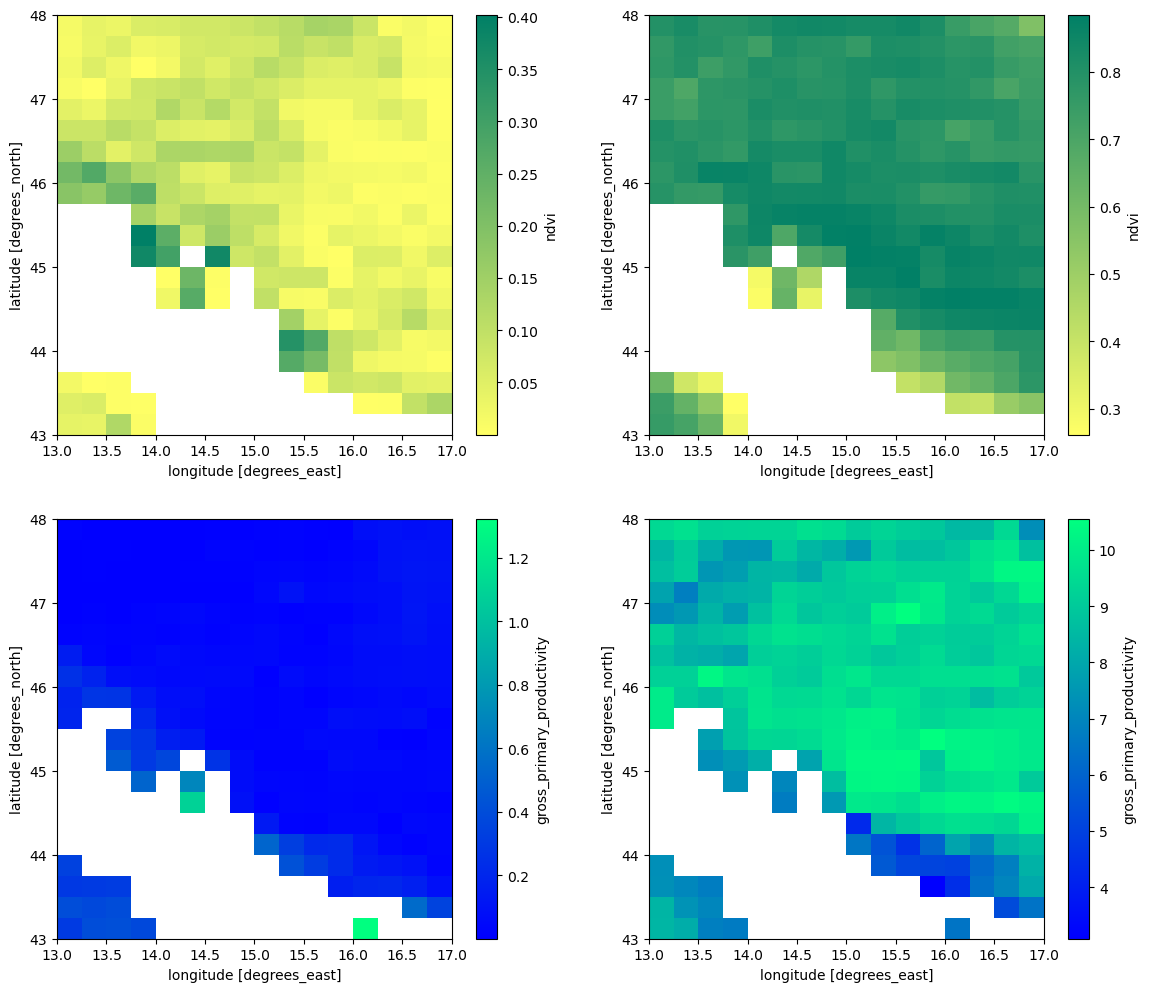

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

ndvi.min(dim="time").plot(ax=ax[0,0], cmap="summer_r")
ndvi.max(dim="time").plot(ax=ax[0,1], cmap="summer_r")

gpp.min(dim="time").plot(ax=ax[1,0], cmap="winter")
gpp.max(dim="time").plot(ax=ax[1,1], cmap="winter")


### min and max of NDVI and GPP in time

### absolute thresholds

In [24]:
### filter high NDVI and low GPP by percentiles?

### find negative correlation over time? 

### set random threshold? (on absolute values; on anomaly)

ndvi_threshold = 0.8
gpp_threshold = 10

condition1 = ((cube.ndvi > ndvi_threshold) & (cube.gross_primary_productivity < gpp_threshold))

ie1 = cube.where(condition1)

In [25]:
ie1

<xarray.Dataset> Size: 2MB
Dimensions:                     (time: 276, lat: 24, lon: 40)
Coordinates:
  * lat                         (lat) float64 192B 48.12 48.38 ... 53.62 53.88
  * lon                         (lon) float64 320B 20.12 20.38 ... 29.62 29.88
  * time                        (time) datetime64[ns] 2kB 2010-01-05 ... 2015...
Data variables:
    ndvi                        (time, lat, lon) float32 1MB nan nan ... nan nan
    gross_primary_productivity  (time, lat, lon) float32 1MB nan nan ... nan nan
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

### pixelwise thresholds by std

In [178]:
cube_std = cube.std(dim="time", skipna=True)
cube_std

<xarray.Dataset> Size: 3kB
Dimensions:                     (lat: 20, lon: 16)
Coordinates:
  * lat                         (lat) float64 160B 43.12 43.38 ... 47.62 47.88
  * lon                         (lon) float64 128B 13.12 13.38 ... 16.62 16.88
Data variables:
    ndvi                        (lat, lon) float32 1kB 0.1272 0.08897 ... 0.1044
    gross_primary_productivity  (lat, lon) float32 1kB 2.388 2.208 ... 1.891

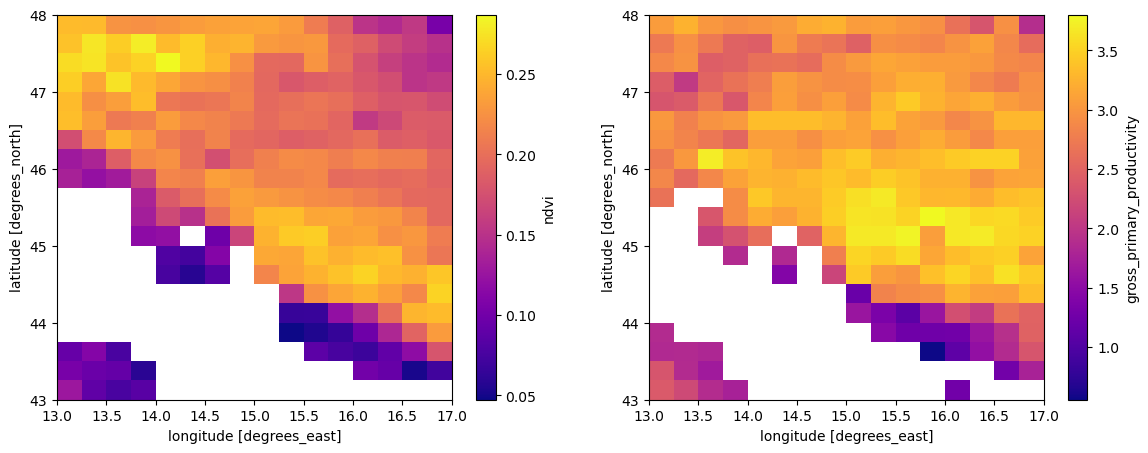

In [179]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

cube_std.ndvi.plot(cmap="plasma", ax=ax[0])
cube_std.gross_primary_productivity.plot(cmap="plasma", ax=ax[1])


In [180]:
### add pixelwise calculated standard deviation and mean of NDVI and GPP 

### calculate per month/ per season instead of over whole time?

### not really necessary to assign as new variables...

cube = cube.assign(ndvi_std = cube.ndvi.std(dim="time", skipna=True))
cube = cube.assign(ndvi_mean = cube.ndvi.mean(dim="time", skipna=True))

cube = cube.assign(gpp_std = cube.gross_primary_productivity.std(dim="time", skipna=True))
cube = cube.assign(gpp_mean = cube.gross_primary_productivity.mean(dim="time", skipna=True))

cube

<xarray.Dataset> Size: 714kB
Dimensions:                     (time: 276, lat: 20, lon: 16)
Coordinates:
  * lat                         (lat) float64 160B 43.12 43.38 ... 47.62 47.88
  * lon                         (lon) float64 128B 13.12 13.38 ... 16.62 16.88
  * time                        (time) datetime64[ns] 2kB 2010-01-05 ... 2015...
Data variables:
    ndvi                        (time, lat, lon) float32 353kB 0.4948 ... 0.3439
    gross_primary_productivity  (time, lat, lon) float32 353kB 0.6609 ... 0.3393
    ndvi_std                    (lat, lon) float32 1kB 0.1272 0.08897 ... 0.1044
    ndvi_mean                   (lat, lon) float32 1kB 0.5646 0.5392 ... 0.3738
    gpp_std                     (lat, lon) float32 1kB 2.388 2.208 ... 1.891
    gpp_mean                    (lat, lon) float32 1kB 3.347 3.232 ... 3.36 2.28
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

In [181]:
### for each pixel: identify when NDVI > mean + 0.5*std and GPP < mean - 0.5*std <-- std*0.5 just to have some results

### no pixel in this subset fulfills that condition
#ndvi_cond = (cube.gross_primary_productivity < (cube.gpp_mean - cube.gpp_std))
#gpp_cond = (cube.ndvi > (cube.ndvi_mean + cube.ndvi_std))

### setting the threshold lower
ndvi_cond = (cube.ndvi > (cube.ndvi_mean + 0.5*cube.ndvi_std))
gpp_cond = (cube.gross_primary_productivity < (cube.gpp_mean - 0.5*cube.gpp_std))

ie_masked = cube.where(ndvi_cond & gpp_cond)
ie_masked


<xarray.Dataset> Size: 2MB
Dimensions:                     (time: 276, lat: 20, lon: 16)
Coordinates:
  * lat                         (lat) float64 160B 43.12 43.38 ... 47.62 47.88
  * lon                         (lon) float64 128B 13.12 13.38 ... 16.62 16.88
  * time                        (time) datetime64[ns] 2kB 2010-01-05 ... 2015...
Data variables:
    ndvi                        (time, lat, lon) float32 353kB nan nan ... nan
    gross_primary_productivity  (time, lat, lon) float32 353kB nan nan ... nan
    ndvi_std                    (lat, lon, time) float32 353kB nan nan ... nan
    ndvi_mean                   (lat, lon, time) float32 353kB nan nan ... nan
    gpp_std                     (lat, lon, time) float32 353kB nan nan ... nan
    gpp_mean                    (lat, lon, time) float32 353kB nan nan ... nan
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

In [182]:
#np.unique(ie_masked.ndvi.values) ### contains not True/ False but the actual values that fulfill the condition

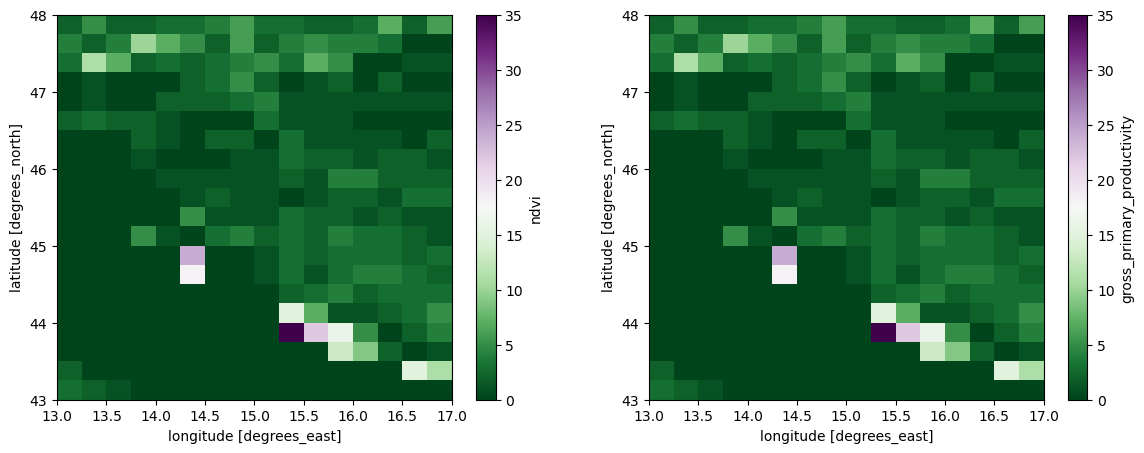

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

### count how often pixels are not-nan in time (for both variables just to emphasize that it is the same, while the dataset still contains the original values)
ie_masked.ndvi.count(dim="time").plot(cmap="BuPu", ax=ax[0])
ie_masked.gross_primary_productivity.count(dim="time").plot(cmap="BuPu", ax=ax[1])


In [184]:
ie_max_pixel = ie_masked.where(ie_masked.ndvi.count(dim="time") == ie_masked.ndvi.count(dim="time").max(), drop=True)
ie_max_pixel


<xarray.Dataset> Size: 9kB
Dimensions:                     (time: 276, lat: 1, lon: 1)
Coordinates:
  * lat                         (lat) float64 8B 43.88
  * lon                         (lon) float64 8B 15.38
  * time                        (time) datetime64[ns] 2kB 2010-01-05 ... 2015...
Data variables:
    ndvi                        (time, lat, lon) float32 1kB 0.4599 ... 0.4399
    gross_primary_productivity  (time, lat, lon) float32 1kB 1.314 ... 1.169
    ndvi_std                    (lat, lon, time) float32 1kB 0.04742 ... 0.04742
    ndvi_mean                   (lat, lon, time) float32 1kB 0.3907 ... 0.3907
    gpp_std                     (lat, lon, time) float32 1kB 1.46 1.46 ... 1.46
    gpp_mean                    (lat, lon, time) float32 1kB 2.954 ... 2.954
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

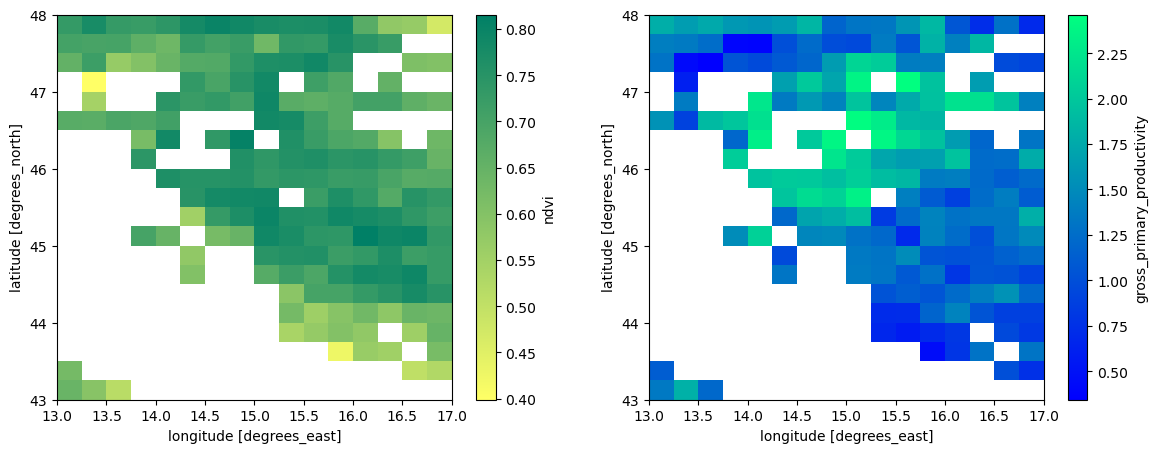

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

### absolute variable values that fall within the masking condition for inefficient ecosystems

ie_masked.ndvi.max(dim="time").plot(cmap="summer_r", ax=ax[0])
ie_masked.gross_primary_productivity.min(dim="time").plot(cmap="winter", ax=ax[1])

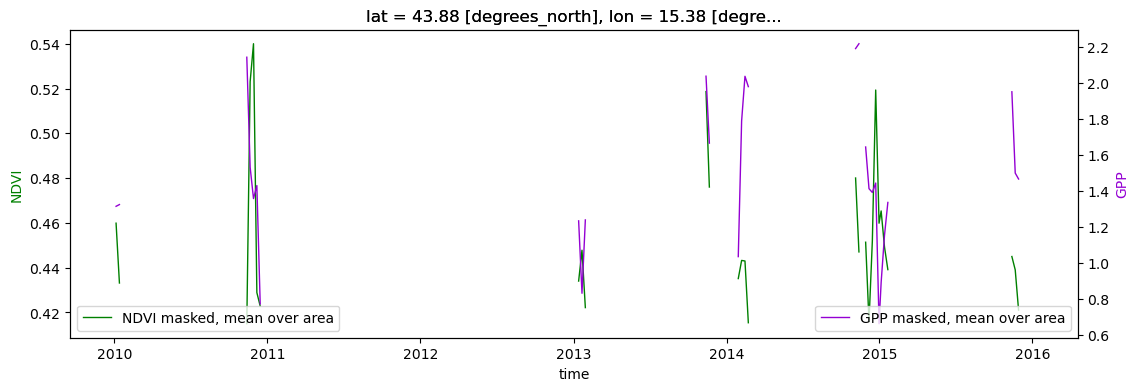

In [187]:
fig, ax = plt.subplots(1, figsize=(13,4))

ax_t = ax.twinx()
ie_max_pixel.ndvi.plot(ax=ax, color="green", lw=1, label="NDVI masked, mean over area")
ie_max_pixel.gross_primary_productivity.plot(ax=ax_t, color="darkviolet", lw=1, label="GPP masked, mean over area")
ax.set_ylabel("NDVI", color="green")
ax_t.set_ylabel("GPP", color="darkviolet")
ax.legend(loc="lower left")
ax_t.legend(loc="lower right")



In [188]:
### group by month to see in which month inefficiency occurs most frequently 

ie_masked_grpd = ie_masked.groupby("time.month")
ie_masked_grpd

<DatasetGroupBy, grouped over 1 grouper(s), 12 groups in total:
    'month': 12/12 groups present with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12>

In [189]:
#ie_masked_grpd.groups

In [110]:
ie_masked_grpd.count()

<xarray.Dataset> Size: 554kB
Dimensions:                     (month: 12, lat: 24, lon: 40)
Coordinates:
  * lat                         (lat) float64 192B 48.12 48.38 ... 53.62 53.88
  * lon                         (lon) float64 320B 20.12 20.38 ... 29.62 29.88
  * month                       (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    ndvi                        (month, lat, lon) int64 92kB 0 0 0 0 ... 0 0 0 0
    gross_primary_productivity  (month, lat, lon) int64 92kB 0 0 0 0 ... 0 0 0 0
    ndvi_std                    (month, lat, lon) int64 92kB 0 0 0 0 ... 0 0 0 0
    gpp_std                     (month, lat, lon) int64 92kB 0 0 0 0 ... 0 0 0 0
    ndvi_mean                   (month, lat, lon) int64 92kB 0 0 0 0 ... 0 0 0 0
    gpp_mean                    (month, lat, lon) int64 92kB 0 0 0 0 ... 0 0 0 0
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

In [119]:
ie_masked_grpd.dims["time"]

/tmp/ipykernel_4220/1319239652.py:1: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ie_masked_grpd.dims["time"]


24

In [ ]:
month1 = ie_masked_grpd.iloc[month==1]  ### why ??? 
#month1 = ie_masked_grpd.sel(time=ie_masked_grpd.time.dt.month == 1) ### sel does not work either...

month1

AttributeError: 'DatasetGroupBy' object has no attribute 'iloc'

In [190]:
ie_masked_grpd_sum = ie_masked.groupby("time.month").sum()

ie_masked_grpd_sum


<xarray.Dataset> Size: 93kB
Dimensions:                     (month: 12, lat: 20, lon: 16)
Coordinates:
  * lat                         (lat) float64 160B 43.12 43.38 ... 47.62 47.88
  * lon                         (lon) float64 128B 13.12 13.38 ... 16.62 16.88
  * month                       (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    ndvi                        (month, lat, lon) float32 15kB 0.0 0.0 ... 0.0
    gross_primary_productivity  (month, lat, lon) float32 15kB 0.0 0.0 ... 0.0
    ndvi_std                    (month, lat, lon) float32 15kB 0.0 0.0 ... 0.0
    ndvi_mean                   (month, lat, lon) float32 15kB 0.0 0.0 ... 0.0
    gpp_std                     (month, lat, lon) float32 15kB 0.0 0.0 ... 0.0
    gpp_mean                    (month, lat, lon) float32 15kB 0.0 0.0 ... 0.0
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

In [137]:
### how can I access the months to plot them ?? 

/tmp/ipykernel_4220/1361510401.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar


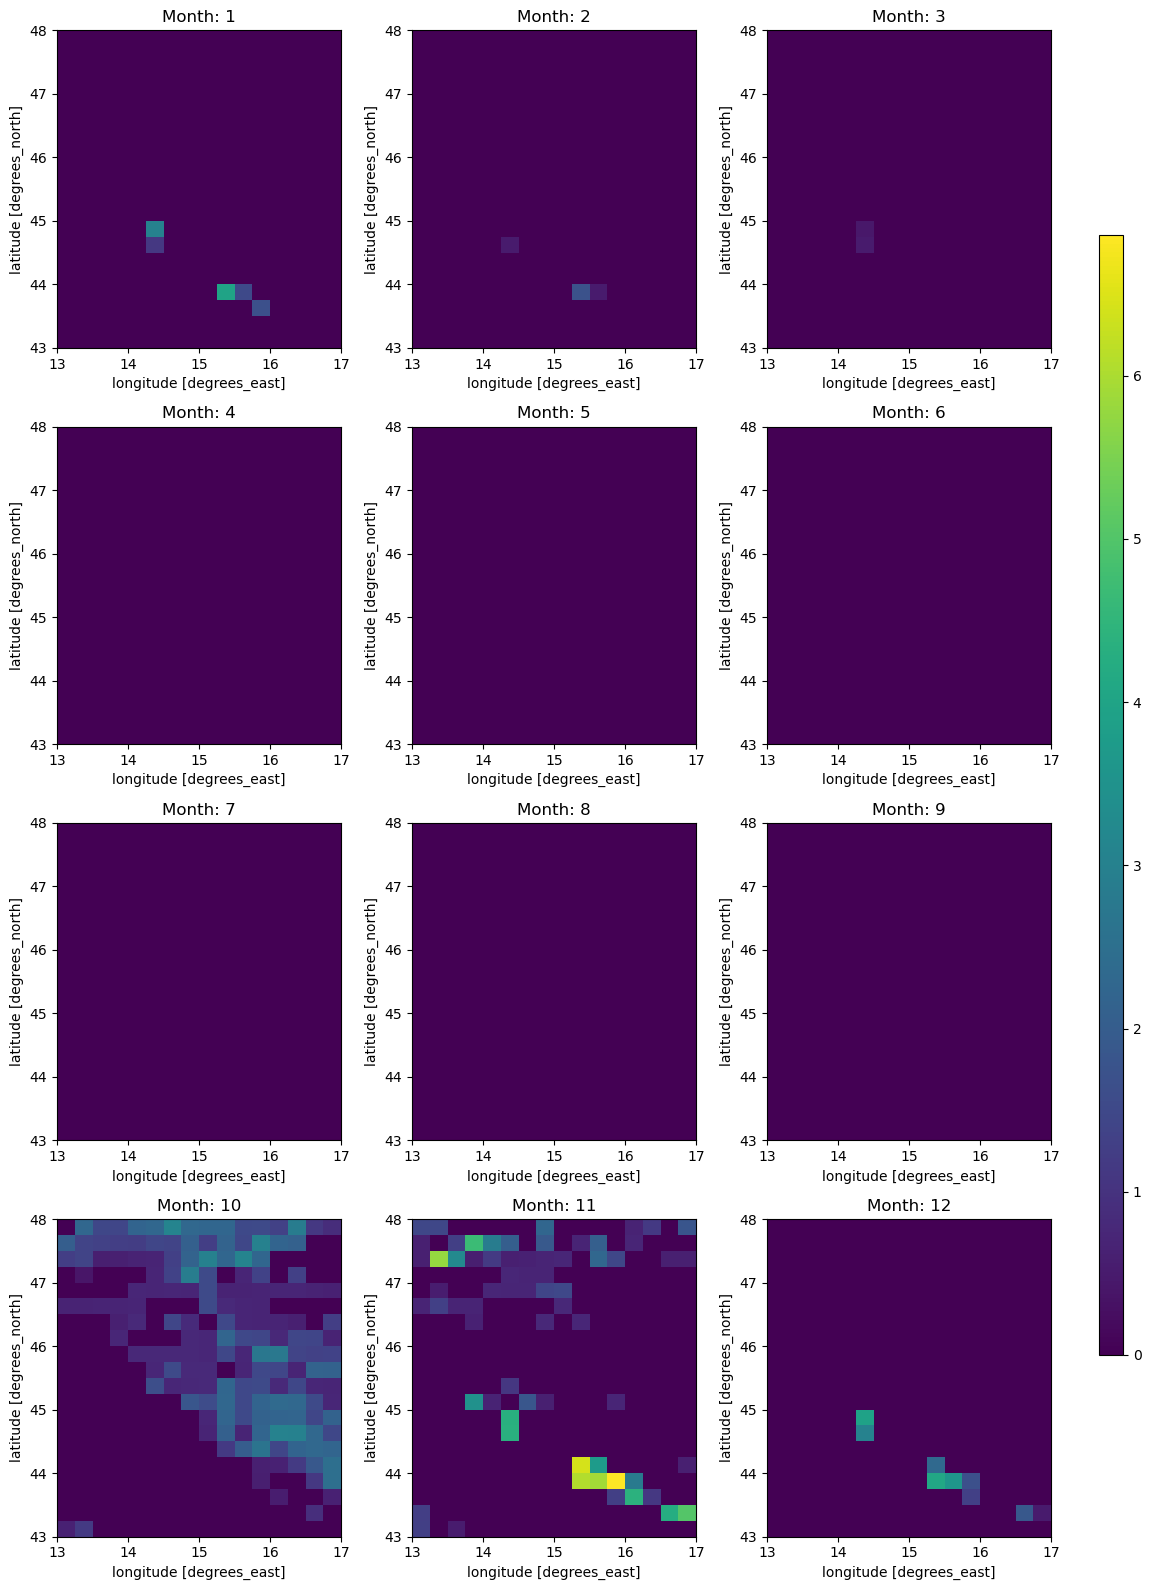

In [191]:
 ### NDVI MSKD (> mean+0.5*std) ABS. VALUES SUMMED MONTHLY

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 16))

# Flatten axes for easy iteration
axes = axes.flatten()

ie_masked_grpd_sum_ndvi = ie_masked_grpd_sum.ndvi

# Set a shared color scale across all plots
vmin = ie_masked_grpd_sum_ndvi.min().values  # Min value across all months
vmax = ie_masked_grpd_sum_ndvi.max().values  # Max value across all months

# Iterate over months and create a map plot for each
for i, month in enumerate(ie_masked_grpd_sum_ndvi.month.values):
    ax = axes[i]
    ie_masked_grpd_sum_ndvi.sel(month=month).plot(
        ax=ax, 
        cmap="viridis",  # Choose a color palette
        vmin=vmin, vmax=vmax,  # Keep colors consistent across months
        add_colorbar=False  # Single colorbar at the end
    )
    ax.set_title(f"Month: {month}")  # Set title for each subplot

# Add a shared colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position for colorbar
plt.colorbar(axes[0].collections[0], cax=cbar_ax)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar
plt.show()

/tmp/ipykernel_4220/2375807455.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar


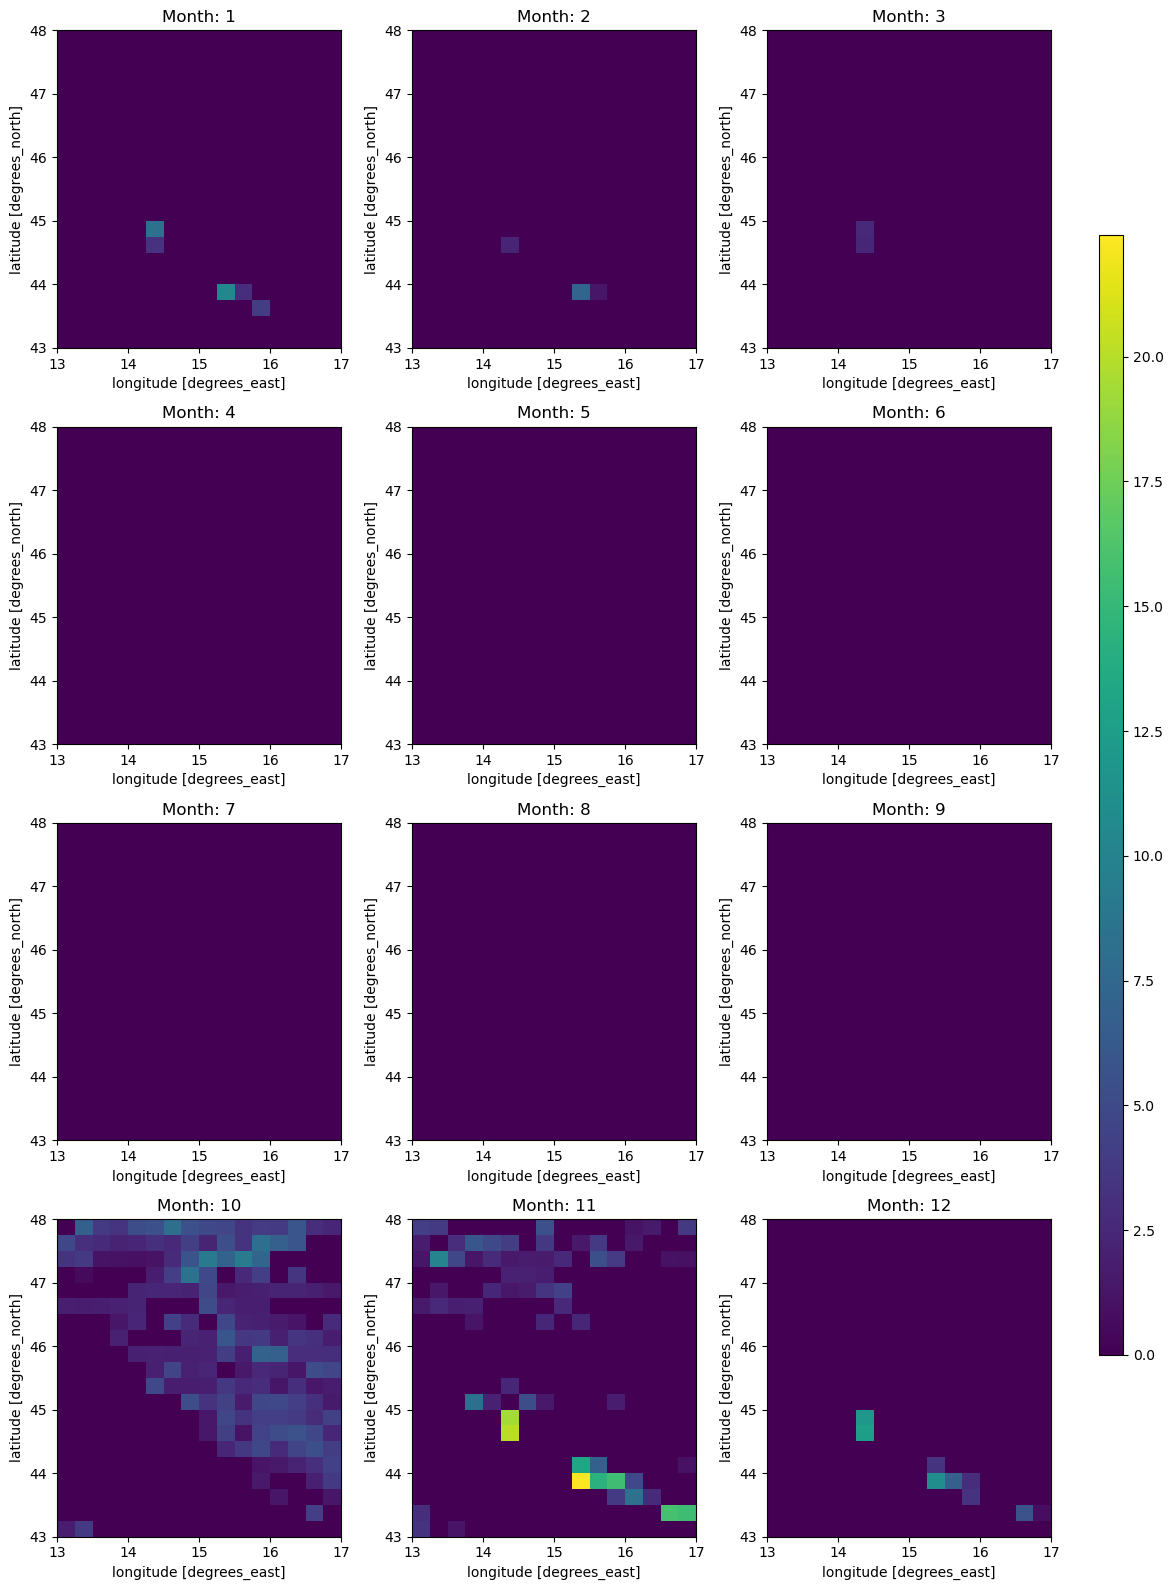

In [192]:
### GPP MSKD (< mean-0.5*std) ABS. VALUES SUMMED MONTHLY

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 16))

# Flatten axes for easy iteration
axes = axes.flatten()

ie_masked_grpd_sum_gpp = ie_masked_grpd_sum.gross_primary_productivity

# Set a shared color scale across all plots
vmin = ie_masked_grpd_sum_gpp.min().values  # Min value across all months
vmax = ie_masked_grpd_sum_gpp.max().values  # Max value across all months

# Iterate over months and create a map plot for each
for i, month in enumerate(ie_masked_grpd_sum_gpp.month.values):
    ax = axes[i]
    ie_masked_grpd_sum_gpp.sel(month=month).plot(
        ax=ax, 
        cmap="viridis",  # Choose a color palette
        vmin=vmin, vmax=vmax,  # Keep colors consistent across months
        add_colorbar=False  # Single colorbar at the end
    )
    ax.set_title(f"Month: {month}")  # Set title for each subplot

# Add a shared colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position for colorbar
plt.colorbar(axes[0].collections[0], cax=cbar_ax)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar
plt.show()

In [112]:
ie_masked.resample(time="M") 

/home/lea/anaconda3/envs/cube_esa/lib/python3.13/site-packages/xarray/groupers.py:487: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


<DatasetResample, grouped over 1 grouper(s), 72 groups in total:
    '__resample_dim__': 72/72 groups present with labels 2010-01-31, ..., 2015-12-31>

### bivariate map

(array([1.02112e+05, 2.92810e+04, 1.55200e+04, 1.21860e+04, 1.04720e+04,
        9.66900e+03, 9.75200e+03, 9.91000e+03, 1.03870e+04, 1.12760e+04,
        1.18220e+04, 1.13770e+04, 9.07100e+03, 5.86000e+03, 3.14500e+03,
        1.35300e+03, 4.88000e+02, 8.30000e+01, 2.30000e+01, 2.00000e+00]),
 array([1.41710043e-05, 6.22412920e-01, 1.24481165e+00, 1.86721039e+00,
        2.48960900e+00, 3.11200786e+00, 3.73440647e+00, 4.35680532e+00,
        4.97920418e+00, 5.60160303e+00, 6.22400188e+00, 6.84640026e+00,
        7.46879911e+00, 8.09119797e+00, 8.71359634e+00, 9.33599567e+00,
        9.95839405e+00, 1.05807924e+01, 1.12031918e+01, 1.18255901e+01,
        1.24479895e+01]),
 <BarContainer object of 20 artists>)

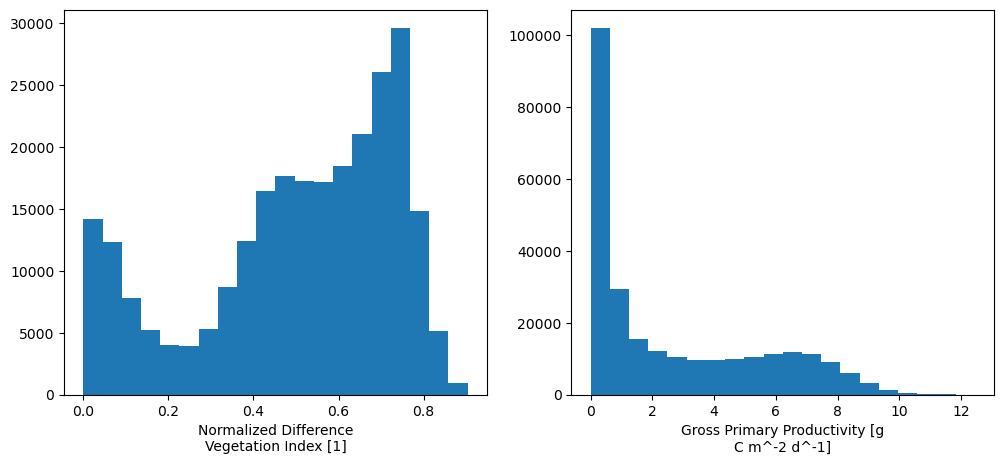

In [29]:
fig, ax = plt.subplots(1,2, figsize=(12, 5))

ndvi.plot.hist(ax=ax[0], bins=20)
gpp.plot.hist(ax=ax[1], bins=20)

In [ ]:
### bin the data

### average by season? month?

In [33]:
ndvi

<xarray.DataArray 'ndvi' (time: 276, lat: 24, lon: 40)> Size: 1MB
array([[[0.202716  , 0.3049077 , 0.4220656 , ...,        nan,
                nan,        nan],
        [0.30130458, 0.43891892, 0.42090577, ...,        nan,
                nan,        nan],
        [0.41540202, 0.4725975 , 0.4546988 , ...,        nan,
                nan,        nan],
        ...,
        [0.08996299, 0.08306087, 0.20042697, ..., 0.10166419,
         0.12138356, 0.14176147],
        [0.1514593 ,        nan, 0.19729446, ..., 0.15673405,
         0.1774316 , 0.09549636],
        [0.10891466, 0.09437601, 0.06255753, ..., 0.110456  ,
         0.09697296, 0.02697252]],

       [[0.35956678, 0.35943273, 0.3908791 , ...,        nan,
                nan,        nan],
        [0.33877167, 0.41174304, 0.43395045, ...,        nan,
                nan,        nan],
        [0.39914525, 0.46369419, 0.39301002, ...,        nan,
                nan,        nan],
...
        [0.51617354, 0.54008937, 0.59689325, ..., 0.2609867 ,
         0.25243497, 0.37079188],
        [0.5362492 ,        nan, 0.56761885, ..., 0.4272176 ,
         0.45655423, 0.39447007],
        [0.43232468, 0.4079672 , 0.38033146, ..., 0.4259484 ,
         0.4574635 , 0.39875972]],

       [[0.45781127, 0.4500404 , 0.45398027, ..., 0.3758193 ,
         0.36479473, 0.33455893],
        [0.4436766 , 0.43423846, 0.43732697, ..., 0.38777333,
         0.3850402 , 0.32947722],
        [0.51096284, 0.48100987, 0.50625044, ..., 0.4133335 ,
         0.3483873 , 0.33155867],
        ...,
        [0.5013505 , 0.5209419 , 0.59590715, ..., 0.14028977,
         0.17626156, 0.28703204],
        [0.5206417 ,        nan, 0.5937574 , ..., 0.2539138 ,
         0.30829257, 0.2953183 ],
        [0.46763074, 0.466988  , 0.45066193, ..., 0.3185968 ,
         0.3750471 , 0.32530728]]], shape=(276, 24, 40), dtype=float32)
Coordinates:
  * lat      (lat) float64 192B 48.12 48.38 48.62 48.88 ... 53.38 53.62 53.88
  * lon      (lon) float64 320B 20.12 20.38 20.62 20.88 ... 29.38 29.62 29.88
  * time     (time) datetime64[ns] 2kB 2010-01-05 2010-01-13 ... 2015-12-31
Attributes: (12/25)
    acknowledgment:             https://lpdaac.usgs.gov/products/mcd43c4v061/
    date_modified:              2022-10-11 23:51:00.603768
    description:                MODIS/Terra+Aqua BRDF/Albedo Nadir BRDF-Adjus...
    geospatial_lat_max:         89.875
    geospatial_lat_min:         -89.87499999998977
    geospatial_lat_resolution:  0.25
    ...                         ...
    standard_name:              NDVI
    temporal_resolution:        8D
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        2000-03-01T00:00:00.000000000
    time_period:                8D
    units:                      1

In [ ]:
bins_ndvi = [0., 0.333, 0.666, 1.]
bins_gpp = [0., 4., 8., 12.]

ndvi_binned = ndvi.groupby_bins(ndvi, bins=bins_ndvi, include_lowest=True)
gpp_binned = gpp.groupby_bins(gpp, bins=bins_gpp, include_lowest=True)

<DataArrayGroupBy, grouped over 1 grouper(s), 3 groups in total:
    'ndvi_bins': 3/3 groups present with labels (-0.001,, 0.333], ..., (0.666,...>

In [ ]:
### then how to plot?

### timeseries anomalies

In [ ]:
ndvi.groupby("time.season")

<DataArrayGroupBy, grouped over 1 grouper(s), 19 groups in total:
    'year': 19/19 groups present with labels 2000, 2001, 2002, ..., 2017, 2018>

In [193]:
### using external methods e.g. 

'''
def decompose_pixel(ts):
    stl = STL(ts) ###, seasonal=12) 
    res = stl.fit()
    return res.trend, res.seasonal, res.resid

ndvi_trend, ndvi_season, ndvi_anomaly = xr.apply_ufunc(
    decompose_pixel, ndvi, 
    input_core_dims=[['time']],
    output_core_dims=[['time'], ['time'], ['time']],
    vectorize=True
)
'''

### NDVI

def decompose_pixelwise(timeseries, period=12, model="additive"):
    #timeseries = xr.DataArray(timeseries)
    #timeseries = timeseries.dropna(dim="time")  # Drop NaNs before decomposition
    if np.isnan(timeseries).all():
        return (timeseries * np.nan, timeseries * np.nan, timeseries * np.nan)
    if np.count_nonzero(~np.isnan(timeseries)) < period:
        return (timeseries * np.nan, timeseries * np.nan, timeseries * np.nan)
    ts_series = pd.Series(timeseries)
    ts_series = ts_series.interpolate(method="linear", limit_direction="both").values
    #if len(timeseries) < period:  # Ensure enough data points
    #    return xr.full_like(timeseries, np.nan), xr.full_like(timeseries, np.nan), xr.full_like(timeseries, np.nan)
    results = seasonal_decompose(ts_series, model=model, period=period)
    return results.trend, results.seasonal, results.resid

valid_mask = ~ndvi.isnull().all(dim="time")
ndvi = ndvi.where(valid_mask)

trend_ndvi, season_ndvi, anomaly_ndvi = xr.apply_ufunc(
    decompose_pixelwise,
    ndvi,  # Do NOT dropna(), handle missing values inside the function
    input_core_dims=[["time"]],
    output_core_dims=[["time"], ["time"], ["time"]],
    vectorize=True,
    dask="parallelized",  # Enables parallel processing for large datasets
    output_dtypes=[ndvi.dtype, ndvi.dtype, ndvi.dtype],  # Ensures correct dtype
    kwargs={"period": 12, "model": "additive"}
)


In [194]:
### GPP

def decompose_pixelwise(timeseries, period=12, model="additive"):
    #timeseries = xr.DataArray(timeseries)
    #timeseries = timeseries.dropna(dim="time")  # Drop NaNs before decomposition
    if np.isnan(timeseries).all():
        return (timeseries * np.nan, timeseries * np.nan, timeseries * np.nan)
    if np.count_nonzero(~np.isnan(timeseries)) < period:
        return (timeseries * np.nan, timeseries * np.nan, timeseries * np.nan)
    ts_series = pd.Series(timeseries)
    ts_series = ts_series.interpolate(method="linear", limit_direction="both").values
    #if len(timeseries) < period:  # Ensure enough data points
    #    return xr.full_like(timeseries, np.nan), xr.full_like(timeseries, np.nan), xr.full_like(timeseries, np.nan)
    results = seasonal_decompose(ts_series, model=model, period=period)
    return results.trend, results.seasonal, results.resid

valid_mask = ~ndvi.isnull().all(dim="time")
gpp = gpp.where(valid_mask)

trend_gpp, season_gpp, anomaly_gpp = xr.apply_ufunc(
    decompose_pixelwise,
    gpp,  # Do NOT dropna(), handle missing values inside the function
    input_core_dims=[["time"]],
    output_core_dims=[["time"], ["time"], ["time"]],
    vectorize=True,
    dask="parallelized",  # Enables parallel processing for large datasets
    output_dtypes=[gpp.dtype, gpp.dtype, gpp.dtype],  # Ensures correct dtype
    kwargs={"period": 12, "model": "additive"}
)


In [45]:


def decompose_pixelwise(timeseries, period=12, model="additive"):
    """
    Decomposes a single pixel's time series into trend, seasonality, and anomaly components.
    
    Args:
        timeseries: Array-like input time series
        period: Seasonal period (default: 12 for monthly data)
        model: Type of decomposition ("additive" or "multiplicative")
        
    Returns:
        Tuple of (trend, seasonal, residual) arrays
    """
    timeseries = np.asarray(timeseries)
    
    # Handle completely NaN pixels
    if np.isnan(timeseries).all():
        return (np.full_like(timeseries, np.nan),
                np.full_like(timeseries, np.nan),
                np.full_like(timeseries, np.nan))
    
    # Check minimum required data points
    if np.count_nonzero(~np.isnan(timeseries)) < period:
        return (np.full_like(timeseries, np.nan),
                np.full_like(timeseries, np.nan),
                np.full_like(timeseries, np.nan))
    
    # Interpolate missing values
    ts_series = pd.Series(timeseries).interpolate(method="linear", limit_direction="both").values
    
    # Perform seasonal decomposition
    results = seasonal_decompose(ts_series, model=model, period=period)
    
    # Return components as separate arrays
    return (results.trend,
            results.seasonal,
            results.resid)

# Step 1: Reshape dataset to (pixels, time)
ndvi_2d = ndvi.stack(pixel=("lat", "lon"))

# Step 2: Drop completely NaN pixels
valid_ndvi = ndvi_2d.dropna(dim="pixel", how="all")

# Step 3: Apply decomposition pixelwise
trend, season, anomaly = xr.apply_ufunc(
    decompose_pixelwise,
    valid_ndvi,
    input_core_dims=[["time"]],
    output_core_dims=[["time"], ["time"], ["time"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[ndvi.dtype, ndvi.dtype, ndvi.dtype],
    kwargs={"period": 12, "model": "additive"}
)

# Step 4: Reconstruct the original shape
trend = trend.unstack("pixel").reindex_like(ndvi)
season = season.unstack("pixel").reindex_like(ndvi)
anomaly = anomaly.unstack("pixel").reindex_like(ndvi)

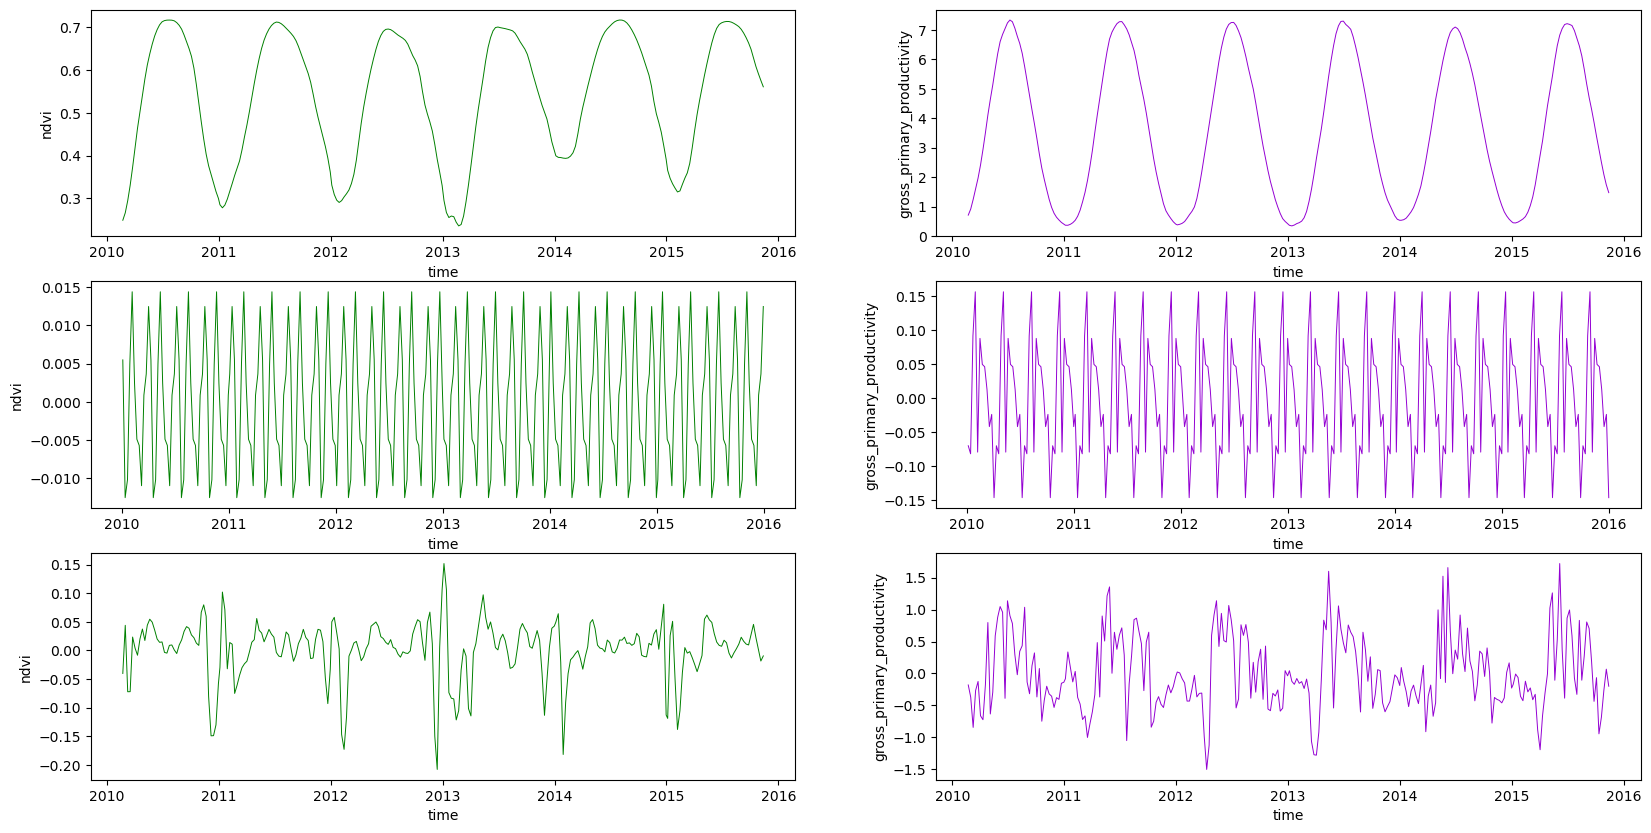

In [195]:
fig, ax = plt.subplots(3, 2, figsize=(20, 10))

trend_ndvi.stack(pixel=("lat", "lon")).mean(dim="pixel").plot(ax=ax[0,0], color="green", linewidth=0.7)
trend_gpp.stack(pixel=("lat", "lon")).mean(dim="pixel").plot(ax=ax[0,1], color="darkviolet", linewidth=0.7)

season_ndvi.stack(pixel=("lat", "lon")).mean(dim="pixel").plot(ax=ax[1,0], color="green", linewidth=0.7)
season_gpp.stack(pixel=("lat", "lon")).mean(dim="pixel").plot(ax=ax[1,1], color="darkviolet", linewidth=0.7)


anomaly_ndvi.stack(pixel=("lat", "lon")).mean(dim="pixel").plot(ax=ax[2,0], color="green", linewidth=0.7)
anomaly_gpp.stack(pixel=("lat", "lon")).mean(dim="pixel").plot(ax=ax[2,1], color="darkviolet", linewidth=0.7)

### mean over all pixels in the area

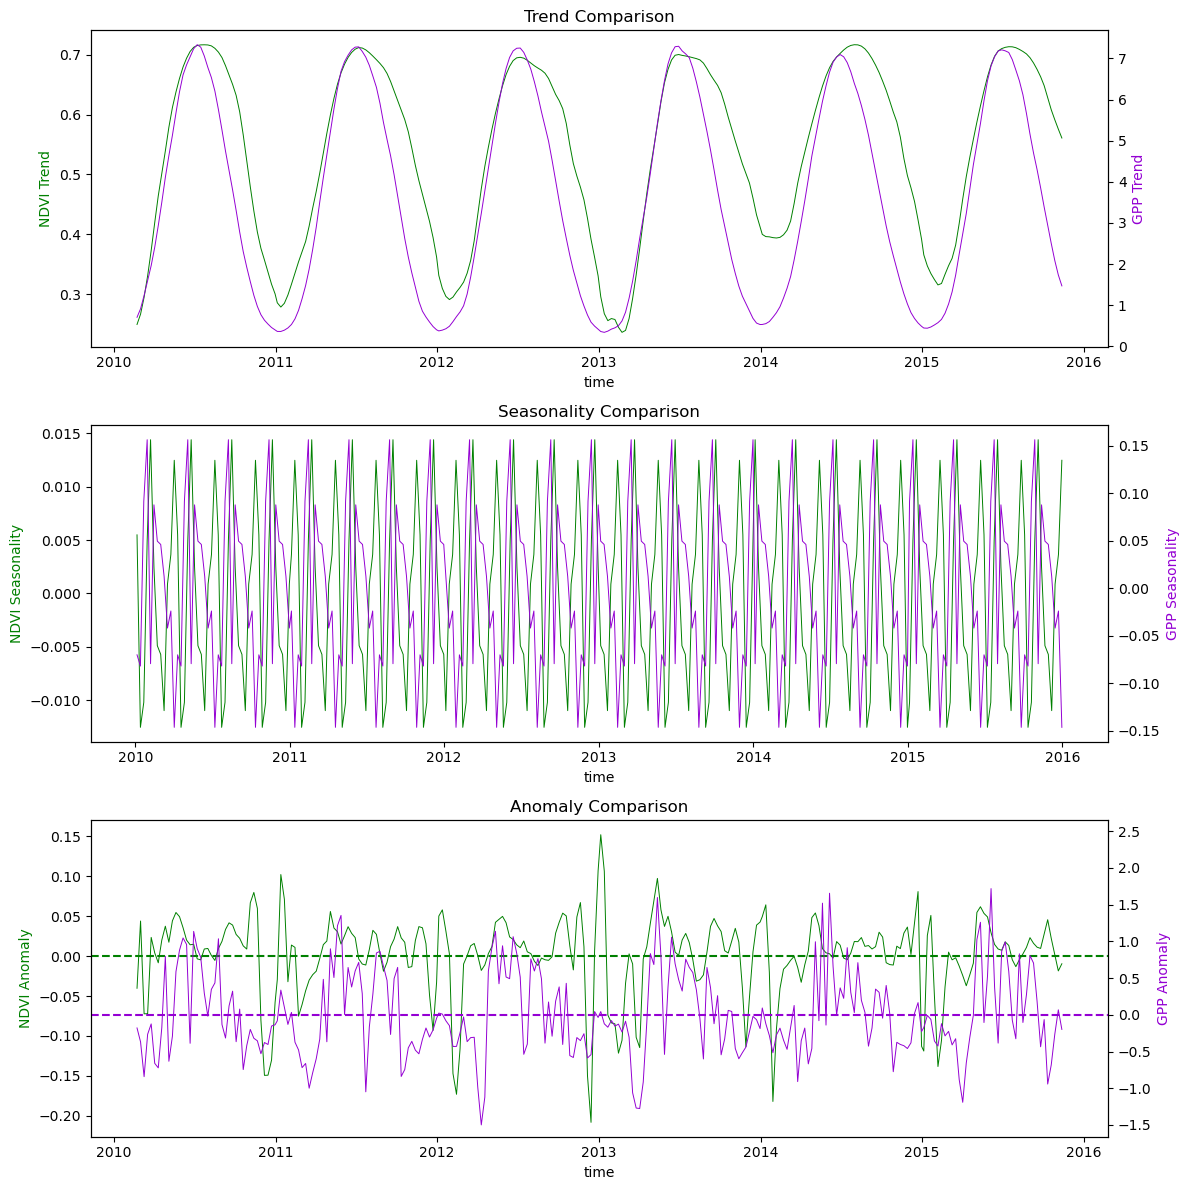

In [ ]:

fig, ax = plt.subplots(3, 1, figsize=(12, 12))  ### one column, three rows

### trend

ax1 = ax[0]
ax2 = ax1.twinx()  ### second y-axis
trend_ndvi.stack(pixel=("lat", "lon")).mean(dim="pixel").plot(ax=ax1, color="green", linewidth=0.7, label="NDVI Trend")
trend_gpp.stack(pixel=("lat", "lon")).mean(dim="pixel").plot(ax=ax2, color="darkviolet", linewidth=0.7, label="GPP Trend")
ax1.set_ylabel("NDVI Trend", color="green")
ax2.set_ylabel("GPP Trend", color="darkviolet")
ax1.set_title("Trend Comparison")
#ax1.legend(loc="upper left")
#ax2.legend(loc="upper right")

### seasonality

ax3 = ax[1]
ax4 = ax3.twinx()
season_ndvi.stack(pixel=("lat", "lon")).mean(dim="pixel").plot(ax=ax3, color="green", linewidth=0.7, label="NDVI Seasonality")
season_gpp.stack(pixel=("lat", "lon")).mean(dim="pixel").plot(ax=ax4, color="darkviolet", linewidth=0.7, label="GPP Seasonality")
ax3.set_ylabel("NDVI Seasonality", color="green")
ax4.set_ylabel("GPP Seasonality", color="darkviolet")
ax3.set_title("Seasonality Comparison")
#ax3.legend(loc="upper left")
#ax4.legend(loc="upper right")

### anomalies (trying to align zero...- fail)
ax5 = ax[2]
ax6 = ax5.twinx()
anomaly_ndvi.stack(pixel=("lat", "lon")).mean(dim="pixel").plot(ax=ax5, color="green", linewidth=0.7, label="NDVI Anomaly")
anomaly_gpp.stack(pixel=("lat", "lon")).mean(dim="pixel").plot(ax=ax6, color="darkviolet", linewidth=0.7, label="GPP Anomaly")
ax5.set_ylabel("NDVI Anomaly", color="green")
ax6.set_ylabel("GPP Anomaly", color="darkviolet")
ax5.set_title("Anomaly Comparison")

### align Zero Level Without Changing Scale
ndvi_min, ndvi_max = ax5.get_ylim()
gpp_min, gpp_max = ax6.get_ylim()

ndvi_zero_pos = abs(ndvi_min) / (ndvi_max - ndvi_min)  ### zero position in axis coordinates
gpp_zero_pos = abs(gpp_min) / (gpp_max - gpp_min)

### adjust limits so that zero aligns
if ndvi_zero_pos > gpp_zero_pos:
    new_gpp_max = gpp_min + (gpp_max - gpp_min) * (ndvi_zero_pos / gpp_zero_pos)
    ax6.set_ylim(gpp_min, new_gpp_max)
else:
    new_ndvi_max = ndvi_min + (ndvi_max - ndvi_min) * (gpp_zero_pos / ndvi_zero_pos)
    ax5.set_ylim(ndvi_min, new_ndvi_max)

ax5.axhline(0, color="green", linestyle="--")  ### zero line
ax6.axhline(0, color="darkviolet", linestyle="--")

#ax5.legend(loc="upper left")
#ax6.legend(loc="upper right")

plt.tight_layout()
plt.show()


### offset between GPP and NDVI in autumn (after peak)

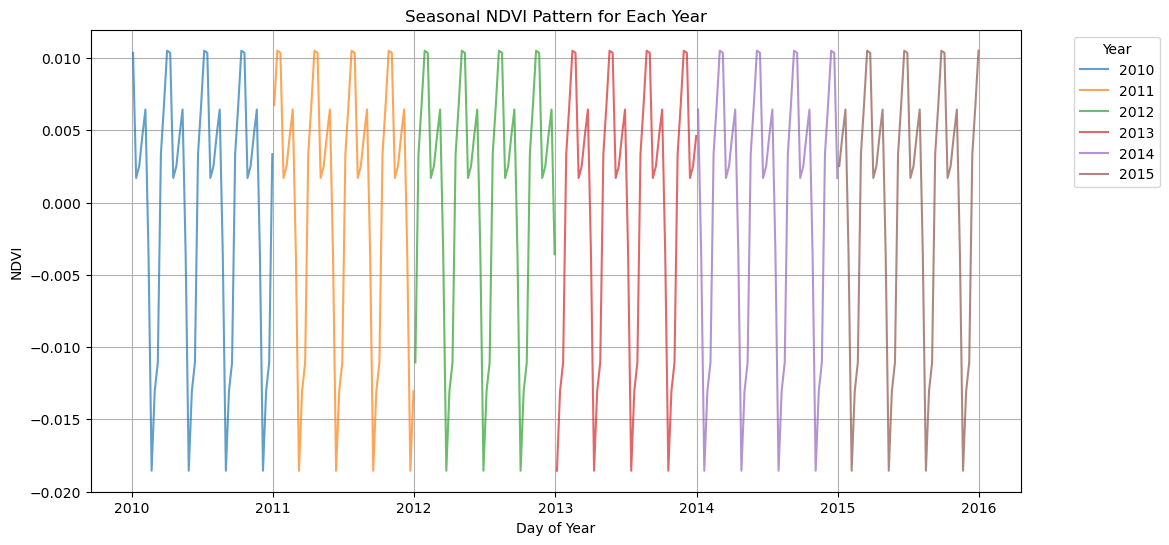

In [ ]:
### trying to plot seasonal pattern into a 12 months plot ("overlapping") ... fail.

season_ndvi_grouped = season_ndvi.groupby("time.year")

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

for year, data in season_ndvi_grouped:
    data.mean(dim=["lat", "lon"]).plot(ax=ax, label=str(year), alpha=0.7)

ax.set_title("NDVI seasonal component")
ax.set_xlabel("Day of Year")
ax.set_ylabel("NDVI")
ax.legend(title="Year", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid()
plt.show()

In [197]:
season_ndvi["time.year"]

<xarray.DataArray 'year' (time: 276)> Size: 2kB
array([2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010,
       2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010,
       2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010,
       2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010,
       2010, 2010, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011,
       2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011,
       2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011,
       2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011,
       2011, 2011, 2011, 2011, 2012, 2012, 2012, 2012, 2012, 2012, 2012,
       2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012,
       2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012,
       2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012,
       2012, 2012, 2012, 2012, 2012, 2012, 2013, 2013, 2013, 2013, 2013,
       2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013,
       2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013,
       2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013,
       2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2014, 2014, 2014,
       2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014,
       2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014,
       2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014,
       2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2015,
       2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015,
       2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015,
       2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015,
       2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015,
       2015])
Coordinates:
  * time     (time) datetime64[ns] 2kB 2010-01-05 2010-01-13 ... 2015-12-31

In [198]:
### extract negative GPP anomalies and positive NDVI anomalies when they occur at the same time on a pixel (set threshold? standard dev. of residuals?)

anomaly_gpp


<xarray.DataArray 'gross_primary_productivity' (lat: 20, lon: 16, time: 276)> Size: 353kB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]],
      shape=(20, 16, 276), dtype=float32)
Coordinates:
  * lat      (lat) float64 160B 43.12 43.38 43.62 43.88 ... 47.38 47.62 47.88
  * lon      (lon) float64 128B 13.12 13.38 13.62 13.88 ... 16.38 16.62 16.88
  * time     (time) datetime64[ns] 2kB 2010-01-05 2010-01-13 ... 2015-12-31

In [199]:
anomaly_ndvi

<xarray.DataArray 'ndvi' (lat: 20, lon: 16, time: 276)> Size: 353kB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]],
      shape=(20, 16, 276), dtype=float32)
Coordinates:
  * lat      (lat) float64 160B 43.12 43.38 43.62 43.88 ... 47.38 47.62 47.88
  * lon      (lon) float64 128B 13.12 13.38 13.62 13.88 ... 16.38 16.62 16.88
  * time     (time) datetime64[ns] 2kB 2010-01-05 2010-01-13 ... 2015-12-31

In [200]:
anomalies = anomaly_ndvi.rename("ndvi_ano").to_dataset().assign(gpp_ano=anomaly_gpp) ### probably better merge or combine or so, but works
anomalies

<xarray.Dataset> Size: 709kB
Dimensions:   (lat: 20, lon: 16, time: 276)
Coordinates:
  * lat       (lat) float64 160B 43.12 43.38 43.62 43.88 ... 47.38 47.62 47.88
  * lon       (lon) float64 128B 13.12 13.38 13.62 13.88 ... 16.38 16.62 16.88
  * time      (time) datetime64[ns] 2kB 2010-01-05 2010-01-13 ... 2015-12-31
Data variables:
    ndvi_ano  (lat, lon, time) float32 353kB nan nan nan nan ... nan nan nan nan
    gpp_ano   (lat, lon, time) float32 353kB nan nan nan nan ... nan nan nan nan

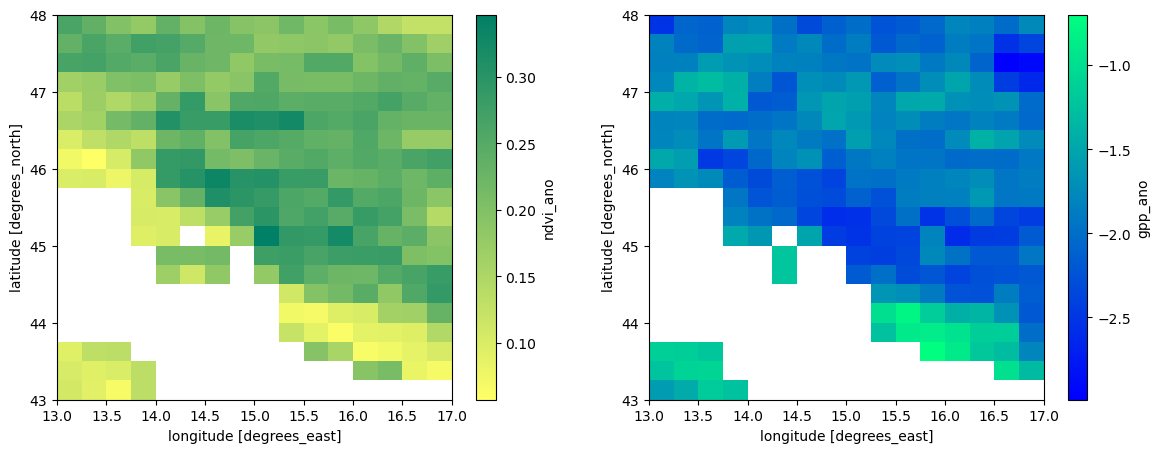

In [201]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

### absolute values that fall within the masking condition for inefficient ecosystems
anomalies.ndvi_ano.max(dim="time").plot(cmap="summer_r", ax=ax[0])
anomalies.gpp_ano.min(dim="time").plot(cmap="winter", ax=ax[1])

In [202]:
anomalies_masked = anomalies.where((anomalies.ndvi_ano > 0)&(anomalies.gpp_ano < 0))
anomalies_masked

<xarray.Dataset> Size: 709kB
Dimensions:   (lat: 20, lon: 16, time: 276)
Coordinates:
  * lat       (lat) float64 160B 43.12 43.38 43.62 43.88 ... 47.38 47.62 47.88
  * lon       (lon) float64 128B 13.12 13.38 13.62 13.88 ... 16.38 16.62 16.88
  * time      (time) datetime64[ns] 2kB 2010-01-05 2010-01-13 ... 2015-12-31
Data variables:
    ndvi_ano  (lat, lon, time) float32 353kB nan nan nan nan ... nan nan nan nan
    gpp_ano   (lat, lon, time) float32 353kB nan nan nan nan ... nan nan nan nan

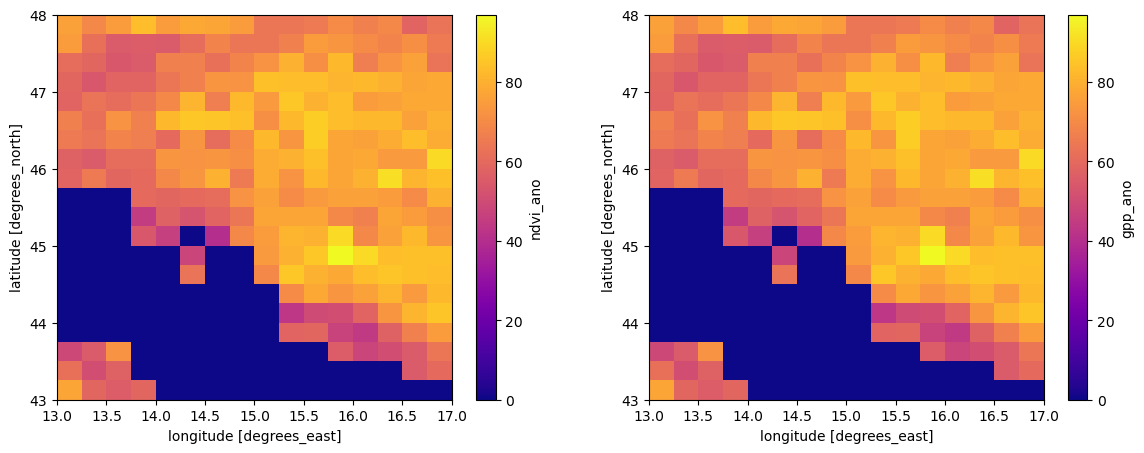

In [203]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

### count how often pixels are not-nan in time (for both variables just to emphasize that it is the same, while the dataset still contains the original values)
anomalies_masked.ndvi_ano.count(dim="time").plot(cmap="plasma", ax=ax[0])
anomalies_masked.gpp_ano.count(dim="time").plot(cmap="plasma", ax=ax[1])

### many anomalies (total number of inefficiency occurences over whole time) if no threshold is set

In [204]:
### calculate standard deviation for anomalies (alas residuals) --> is that a valid approach?

### std pre-masking

### add standard deviation and mean (per pixel, over time) to dataset (there certainly is a more elegant way)

anomalies = anomalies.assign(ndvi_ano_std = anomalies.ndvi_ano.std(dim="time", skipna=True))
anomalies = anomalies.assign(ndvi_ano_mean = anomalies.ndvi_ano.mean(dim="time", skipna=True))

anomalies = anomalies.assign(gpp_ano_std = anomalies.gpp_ano.std(dim="time", skipna=True))
anomalies = anomalies.assign(gpp_ano_mean = anomalies.gpp_ano.mean(dim="time", skipna=True))

anomalies

<xarray.Dataset> Size: 714kB
Dimensions:        (lat: 20, lon: 16, time: 276)
Coordinates:
  * lat            (lat) float64 160B 43.12 43.38 43.62 ... 47.38 47.62 47.88
  * lon            (lon) float64 128B 13.12 13.38 13.62 ... 16.38 16.62 16.88
  * time           (time) datetime64[ns] 2kB 2010-01-05 ... 2015-12-31
Data variables:
    ndvi_ano       (lat, lon, time) float32 353kB nan nan nan ... nan nan nan
    gpp_ano        (lat, lon, time) float32 353kB nan nan nan ... nan nan nan
    ndvi_ano_std   (lat, lon) float32 1kB 0.05624 0.042 ... 0.0528 0.0474
    ndvi_ano_mean  (lat, lon) float32 1kB 0.0009662 0.00043 ... 0.001172
    gpp_ano_std    (lat, lon) float32 1kB 0.6105 0.6012 0.4977 ... 0.7696 0.5879
    gpp_ano_mean   (lat, lon) float32 1kB 0.01009 0.01116 ... 0.006472 0.005831

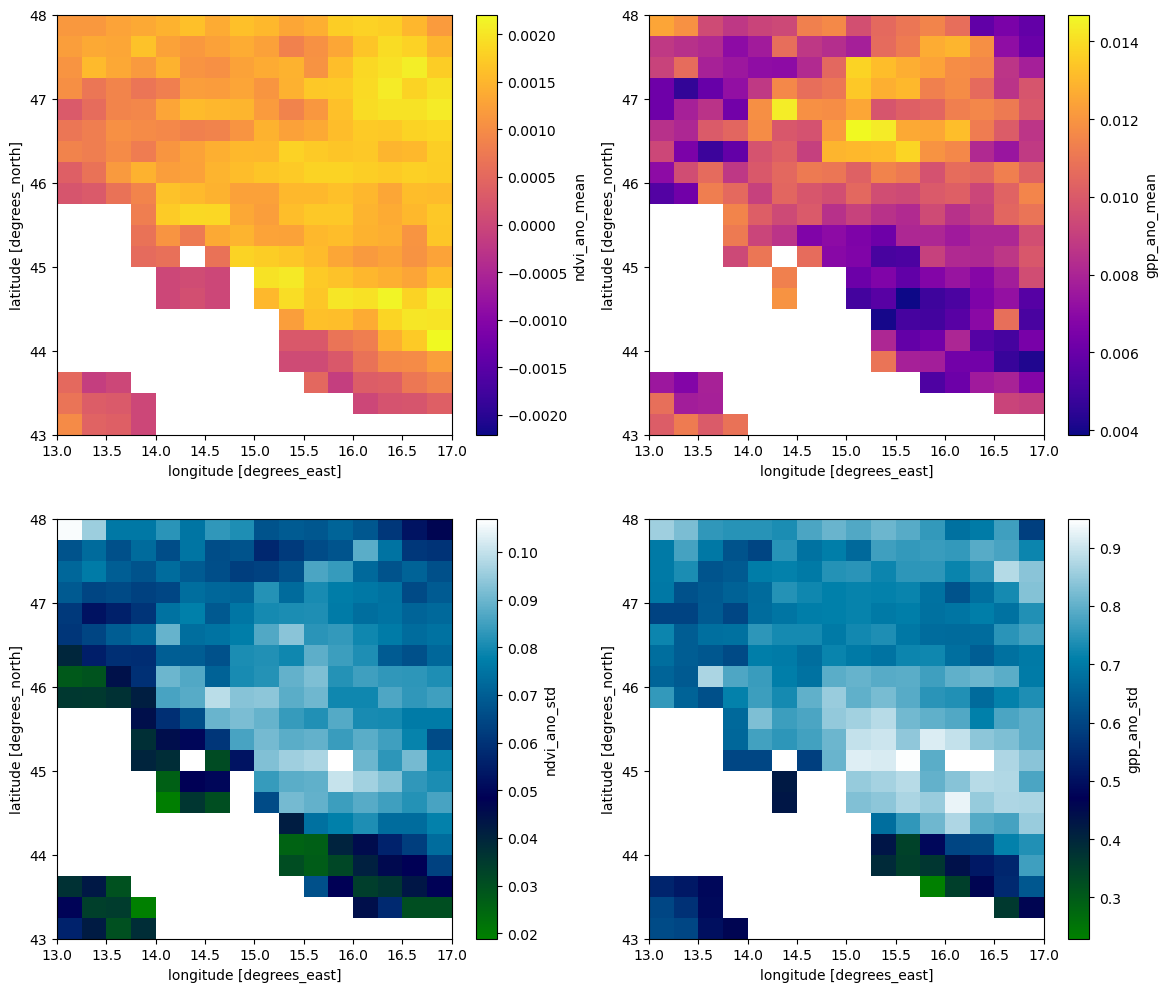

In [205]:
fig, ax = plt.subplots(2,2, figsize=(14, 12))

anomalies.ndvi_ano_mean.plot(ax=ax[0,0], cmap="plasma")
anomalies.gpp_ano_mean.plot(ax=ax[0,1], cmap="plasma")
anomalies.ndvi_ano_std.plot(ax=ax[1,0], cmap="ocean")
anomalies.gpp_ano_std.plot(ax=ax[1,1], cmap="ocean")

### left: NDVI, right: GPP

In [206]:
### mask time series anomalies anomalies by mean and +/- std (same as in original data) ... OVERWRITES PREVIOUS MASKING

ndvi_cond = (anomalies.ndvi_ano > (anomalies.ndvi_ano_mean + anomalies.ndvi_ano_std))
gpp_cond = (anomalies.gpp_ano < (anomalies.gpp_ano_mean - anomalies.gpp_ano_std))

anomalies_masked = anomalies.where(ndvi_cond & gpp_cond)
anomalies_masked


<xarray.Dataset> Size: 2MB
Dimensions:        (lat: 20, lon: 16, time: 276)
Coordinates:
  * lat            (lat) float64 160B 43.12 43.38 43.62 ... 47.38 47.62 47.88
  * lon            (lon) float64 128B 13.12 13.38 13.62 ... 16.38 16.62 16.88
  * time           (time) datetime64[ns] 2kB 2010-01-05 ... 2015-12-31
Data variables:
    ndvi_ano       (lat, lon, time) float32 353kB nan nan nan ... nan nan nan
    gpp_ano        (lat, lon, time) float32 353kB nan nan nan ... nan nan nan
    ndvi_ano_std   (lat, lon, time) float32 353kB nan nan nan ... nan nan nan
    ndvi_ano_mean  (lat, lon, time) float32 353kB nan nan nan ... nan nan nan
    gpp_ano_std    (lat, lon, time) float32 353kB nan nan nan ... nan nan nan
    gpp_ano_mean   (lat, lon, time) float32 353kB nan nan nan ... nan nan nan

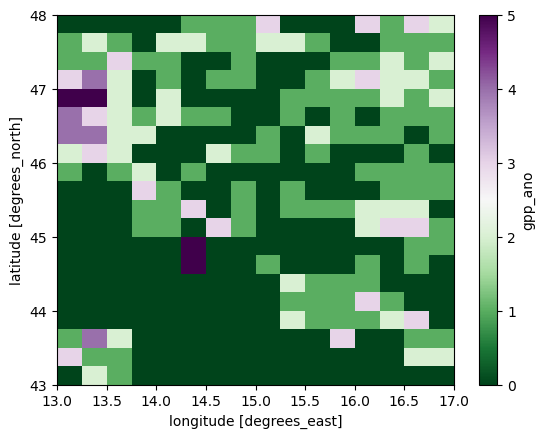

In [ ]:
anomalies_masked.gpp_ano.count(dim="time").plot(cmap="BuPu") 

### count of not-nan timesteps (timesteps where ecosystem was inefficient) - doesn't matter whether we plot gpp or ndvi

above: time series residuals (~ anomalies).


below: original data (not anomalies).

- subset without empty pixels:

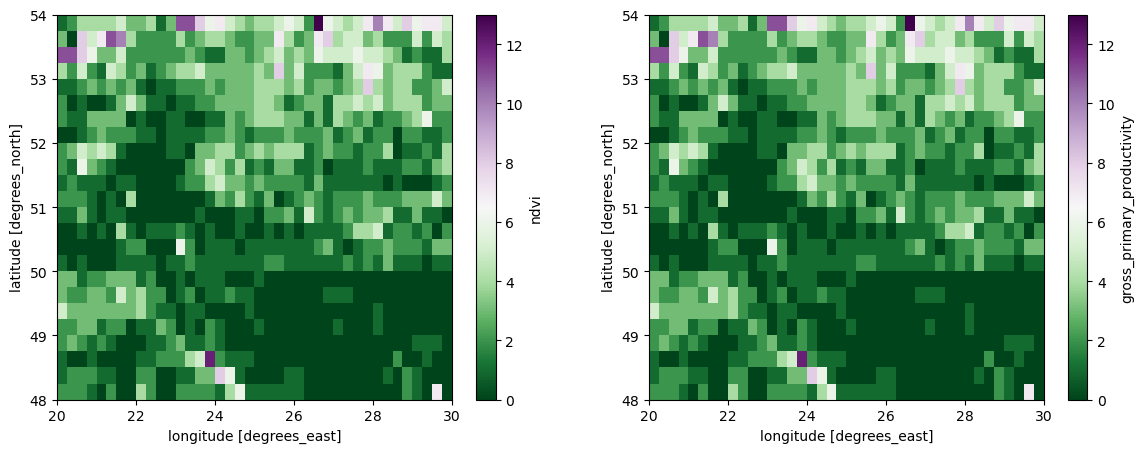


- subset with empty pixels:

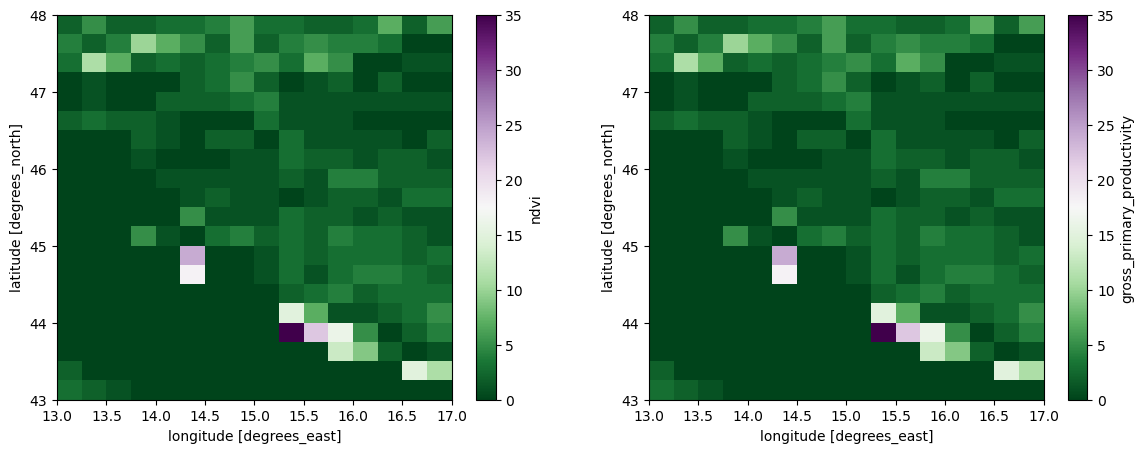

### end